 # Data processing project 

# Part one: Visualization 

In [1]:
# import modules 
import pandas as pd
import numpy as np
import itertools 
import os.path
import glob
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

Let us first load the data

In [2]:
# set the data directory for different mice
csv_dir = "data\csv_results"
wild_type_folders = ["mouse_2","mouse_5"]
ko_folders = ["mouse_4","mouse_6"]    

In [3]:
def process_csv_folder(csv_dir,csv_folder, genotype):
    """ Loads csv files into Data Frames.
    
    Input:
    - csv_dir --> directory where all mice are 
    - csv_folder --> Folder of a specific mouse where all image folders are stored
    - genotype --> Which genotye the current mouse is (wt or ko)
    
    Output:
    - extracted_data --> A Data Frame of all csv files for all images in csv_folder.
    
    """
   
    # Initialize an empty dataframe to store the data
    extracted_data = pd.DataFrame()  
    
    # Get image folders
    image_folders = os.listdir(os.path.join(csv_dir, csv_folder))
    
    # Access image folders
    for image in image_folders:
        
        # Get the path of the data
        csv_path = glob.glob(os.path.join(csv_dir, csv_folder, image, '*.csv'))
        print(f"Importing data from {csv_path[0]}")
        
        # Load csv into dataframe
        image_df = pd.read_csv(csv_path[0], index_col=False)
        
        # Add relevant information to the dataframe
        image_df['genotype'] = genotype
        image_df['image_name'] = image
        image_df['mouse_name'] = csv_folder
        
        # add a column that uniquely identifies an image and mouse combination
        image_df['unique_image_id'] = image_df['mouse_name'] + '_' +image_df['image_name'] 
        
        # Concatenate the image_df with the data dataframe
        extracted_data = pd.concat([ extracted_data,image_df], ignore_index = True)
    
    return extracted_data


# apply the function to load data 
data = pd.DataFrame ()
for wt_folder,ko_folder in zip(wild_type_folders,ko_folders):
    wt_data = process_csv_folder(csv_dir,wt_folder, 'wt')
    ko_data = process_csv_folder(csv_dir,ko_folder, 'ko')
    data = pd.concat([data,wt_data])
    data = pd.concat([data,ko_data])
    
# delete indices not needed
data = data.drop(data.columns[0], axis=1)

Importing data from data\csv_results\mouse_2\image_1\results.csv
Importing data from data\csv_results\mouse_2\image_2\results.csv
Importing data from data\csv_results\mouse_2\image_3\results.csv
Importing data from data\csv_results\mouse_4\image_1\results.csv
Importing data from data\csv_results\mouse_4\image_2\results.csv
Importing data from data\csv_results\mouse_4\image_3\results.csv
Importing data from data\csv_results\mouse_5\image_1\results.csv
Importing data from data\csv_results\mouse_5\image_2\results.csv
Importing data from data\csv_results\mouse_5\image_3\results.csv
Importing data from data\csv_results\mouse_6\image_1\results.csv
Importing data from data\csv_results\mouse_6\image_2\results.csv
Importing data from data\csv_results\mouse_6\image_3\results.csv


Next we will visualize the data to do a basic inspection. We start by looking at the number of detected neurons (or rings around neurons)

In [4]:
# make bar plot of number of neurons per mouse

# group by mice 
gb_mouse = data.groupby('mouse_name').size().reset_index(name = "neuron_number")

# create an altair plot
alt.Chart(gb_mouse).mark_bar(size = 100).encode(
    x=alt.X('mouse_name', title='Mouse', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('neuron_number', title='Neuron count')
).properties(
    title = 'Number of neurons per mouse',
    width = 600
).configure_axis(
    labelFontSize=14,
    titleFontSize=12
)


alt.Chart(...)

In [5]:
# make a plot to examine neuron numbers in individual images 

# group on mice and images
gb_mouse_image = data.groupby(['mouse_name','image_name']).size().reset_index(name = "neuron_number")

# create an altair plot
alt.Chart(gb_mouse_image).mark_bar(size = 20).encode(
    column = alt.Column('mouse_name',header=alt.Header(labelFontSize=17)),
    x=alt.X('image_name', title='', axis=alt.Axis(labelAngle=-45,labelFontSize = 17)),
    y=alt.Y('neuron_number', title='Neuron count')
).properties(
    title = 'Numbe of neurons per mouse',
    width = 100).configure_axis(
    labelFontSize=17,
    titleFontSize=17
)


alt.Chart(...)

There seems to be something fishy with image_3 from mouse 5. We next look at the number of neurons without any synapses.

In [6]:
# see how many neurons without any synapses

# groupby mice and images
gb_empty_rings= data.groupby(['mouse_name','image_name'])['number_of_empty_rings'].sum().reset_index(name = 'empty_rings')

# plot
alt.Chart(gb_empty_rings).mark_bar(size = 20).encode(
    column = alt.Column('mouse_name',header=alt.Header(labelFontSize=17)),
    x=alt.X('image_name', title='', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('empty_rings', title='Number of empty rings')
).properties(
    title = 'Numbe of neurons per mouse',
    width = 100).configure_axis(
    labelFontSize=17,
    titleFontSize=17
)

alt.Chart(...)

We exclude image_3 from mouse_5 from the analyis, since there probably was an error in the image processing.

In [7]:
# Exclude data from image 3 of mouse 5 
delete_these = (data ['image_name'] == 'image_3') & (data['mouse_name'] == 'mouse_5')
data = data[~delete_these]


Next we visualize the data of interest: our synapses.

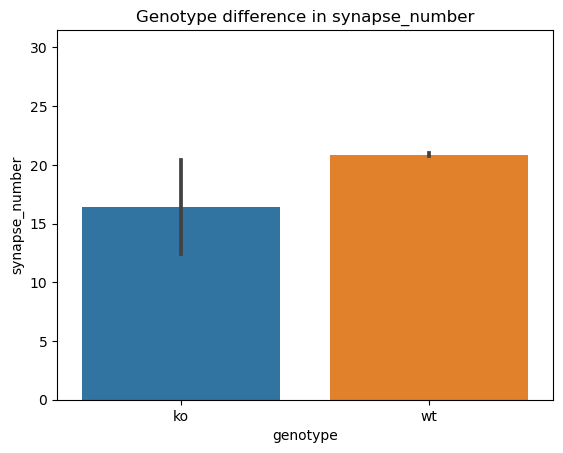

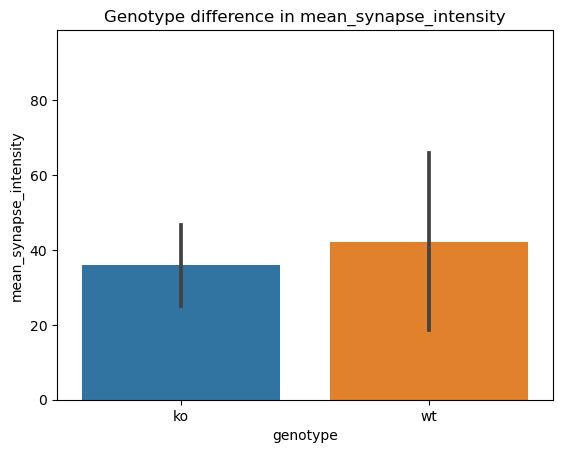

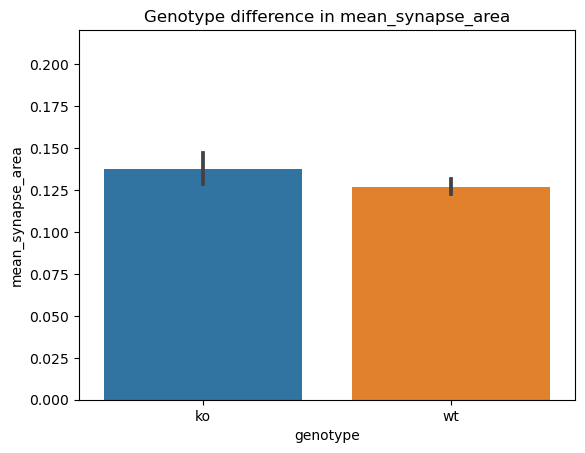

In [8]:
# Create a number by area variable to see how many synapses there are in a given ring around a neuron
data['number_by_area'] = data['synapse_number'] / data['ring_area']


# Compare synapse number around neurons (in rings) per condition
def compare_genotype_only (what_to_compare,p_value = -1 ):
    """ Creates a bar plot with one bar per genotype compating average values
    while averaging over mice.
    
    Input:
    - what_to_compare --> Zhe name of the dependet variable
    - p_value --> The p-value to plot. If set to -1 then none will be plotted
    Furthermore requires a Data Frame called 'data' with columns 'genotype' and 'mouse_name' """
    
    # group data on genotype and mice
    gropued_on_mice = data.groupby(['genotype','mouse_name'])[what_to_compare].mean().reset_index(name = what_to_compare)

    # plot in a bar graph
    ax = sns.barplot(data=gropued_on_mice, x='genotype', y=what_to_compare)
    ax.set(title = f'Genotype difference in {what_to_compare}',ylim= [0,1.5*gropued_on_mice[what_to_compare].max()])
    
    # anotate p_value if present
    if p_value != -1:
        ax.annotate(f'p-value = {p_value:.4f}', xy=(0.5, 0.9), xycoords='axes fraction', ha='center')
    
    plt.show()

# call the function to see results
compare_genotype_only('synapse_number')
compare_genotype_only('mean_synapse_intensity')
compare_genotype_only('mean_synapse_area')


Next a visualization where we can see individual mice and individual images as well, plotted as dots over mice bars. We will call the function once we also have some statistics, since this is the main plotting function I will use in the entire project

In [9]:
# function to create a plot comparing wt and ko in a barplot, with different mice corresponding to different bars
def plot_mice_and_images (df,what_to_compare,p_value = -1,ax_to_plot_on = None):
    """ Plots a bar graph where one mouse has one bar and the bars are grouped by genotype. 
    Image means are overlayed as scatter points on the mice.
    
    Inputs:
    - df --> Data Frame with data 
    - what_to_compare --> Column name of the dependent variable 
    - p_value --> The p-value to plot. If set to -1 then none will be plotted
    - ax_to_plot_on --> an axes object where the plot should be plotted on 
    
    Furthermore requires Data Frame columns 'genotype' and 'mouse_name'
    
    Output:
    - ax --> the image axes object plotted on.
     """
    
    # get data to plot
    gropued_on_mice = df.groupby(['genotype','mouse_name'])[what_to_compare].mean().reset_index(name = 'mean_val')
    grouped_on_images = df.groupby(['genotype','mouse_name','image_name'])[what_to_compare].mean().reset_index(name = 'mean_val')

    # colors to use for genotypes 
    colors_of_genotypes = {'wt':'blue','ko':'red'}
    
    # plot bars of mice
    ax = sns.barplot(data=gropued_on_mice, x='mouse_name', y='mean_val',hue = 'genotype',
                     dodge=False,palette=colors_of_genotypes,ax = ax_to_plot_on)
    ax.set(title = f'Genotype difference in {what_to_compare}',ylim= [0,1.5*gropued_on_mice['mean_val'].max()],
          ylabel =what_to_compare,xlabel= 'Mouse name')
    
    # plot individual image means
    sns.stripplot(data=grouped_on_images, x='mouse_name', y='mean_val', dodge=True, jitter=True, ax=ax, color = 'black')

    
    if p_value != -1:
        ax.annotate(f'p-value = {p_value:.4f}', xy=(0.5, 0.9), xycoords='axes fraction', ha='center')
    
    return(ax)

Let us also create a bar plot where different images have different bars.

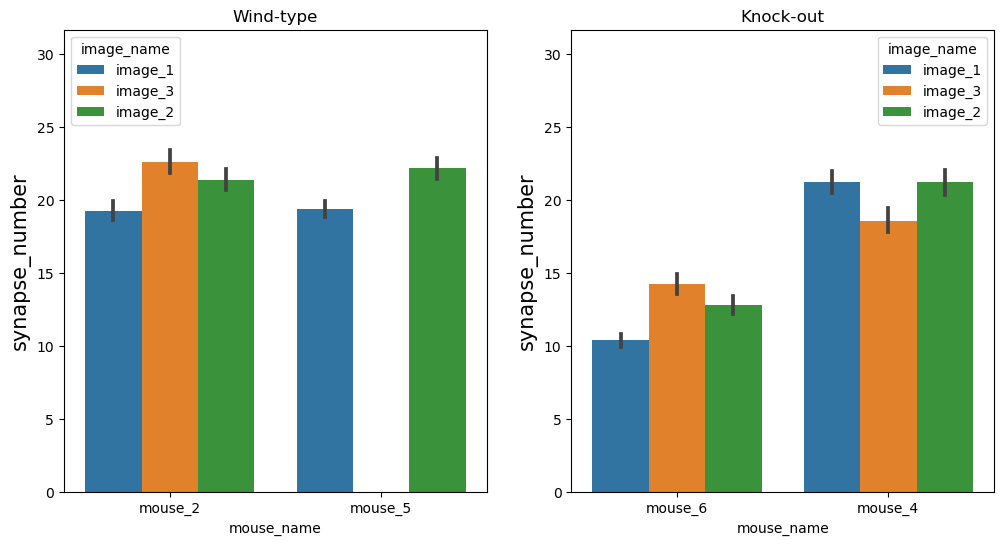

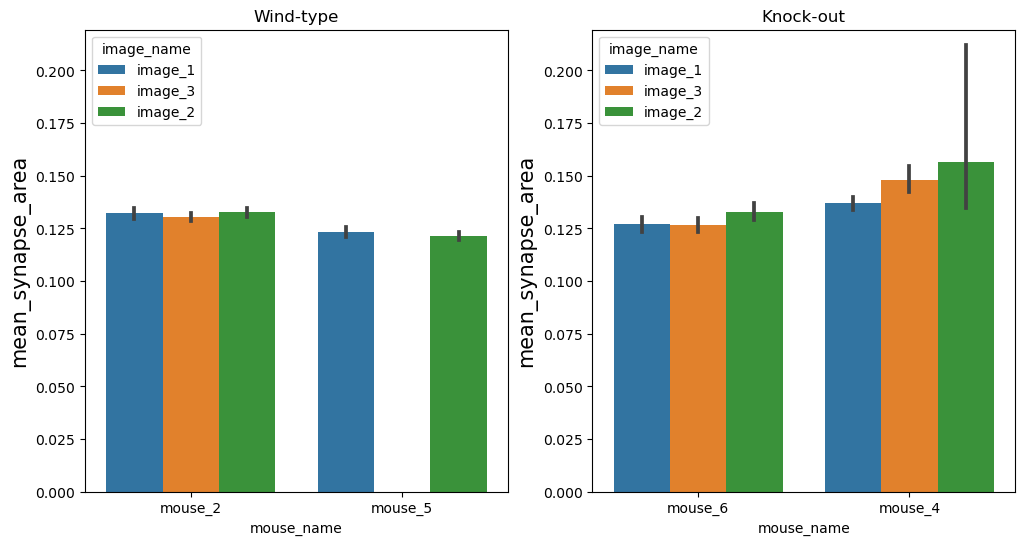

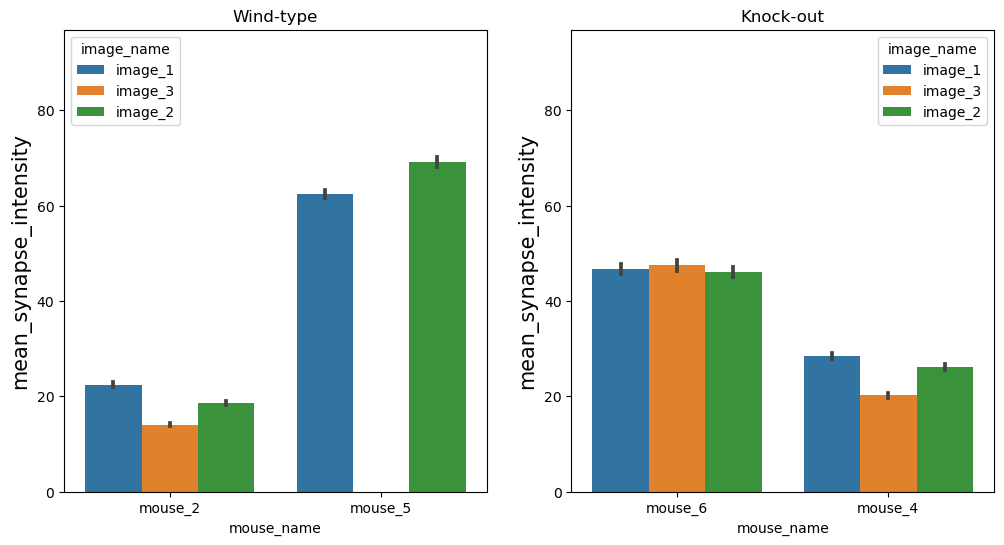

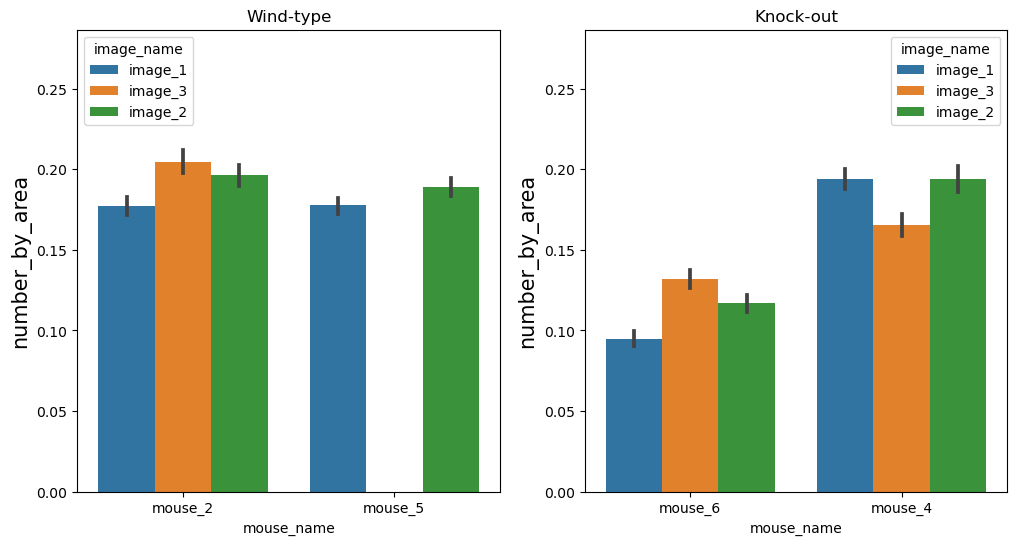

In [10]:
# sort df according to genotypes
sort_genotype = data.sort_values('genotype', key = lambda x: x == 'wt',ascending=False,ignore_index= True) 


def simple_wt_ko_comparison (what_to_compare):
    """Creats a bar plot comparing different images in different bars.
    
    Requires a data frame called sort_genotype, with columns 'genotype','unique_image_id','mouse_name','image_name'
    
    Input:
    what_to_compare --> Column name of dependent variable"""
    
    # create figure canvas and two axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # get limit of  y axes 
    y_limit = [0,1.4*sort_genotype.groupby('unique_image_id')[what_to_compare].mean().max()]
    
    # get data 
    wt_data = sort_genotype[sort_genotype['genotype'] == 'wt']
    ko_data = sort_genotype[sort_genotype['genotype'] == 'ko']
    
    sns.barplot(data=wt_data, x='mouse_name', y=what_to_compare, hue='image_name', ax=ax1)
    ax1.set_title('Wind-type')
    ax1.set(ylim = y_limit)
    ax1.set_ylabel(what_to_compare,fontsize = 15)

    # plot ko on the right
    sns.barplot(data=ko_data, x='mouse_name', y=what_to_compare, hue='image_name', ax=ax2)
    ax2.set_title('Knock-out')
    ax2.set(ylim = y_limit)
    ax2.set_ylabel(what_to_compare,fontsize = 15)


    plt.show()

# call function to plot results
simple_wt_ko_comparison('synapse_number')
simple_wt_ko_comparison('mean_synapse_area')
simple_wt_ko_comparison('mean_synapse_intensity')
simple_wt_ko_comparison('number_by_area')

# Part two: Statistical analysis 

We first start by inspecting the data for outliers by using a box plot

In [11]:
# import some statistics modules
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan

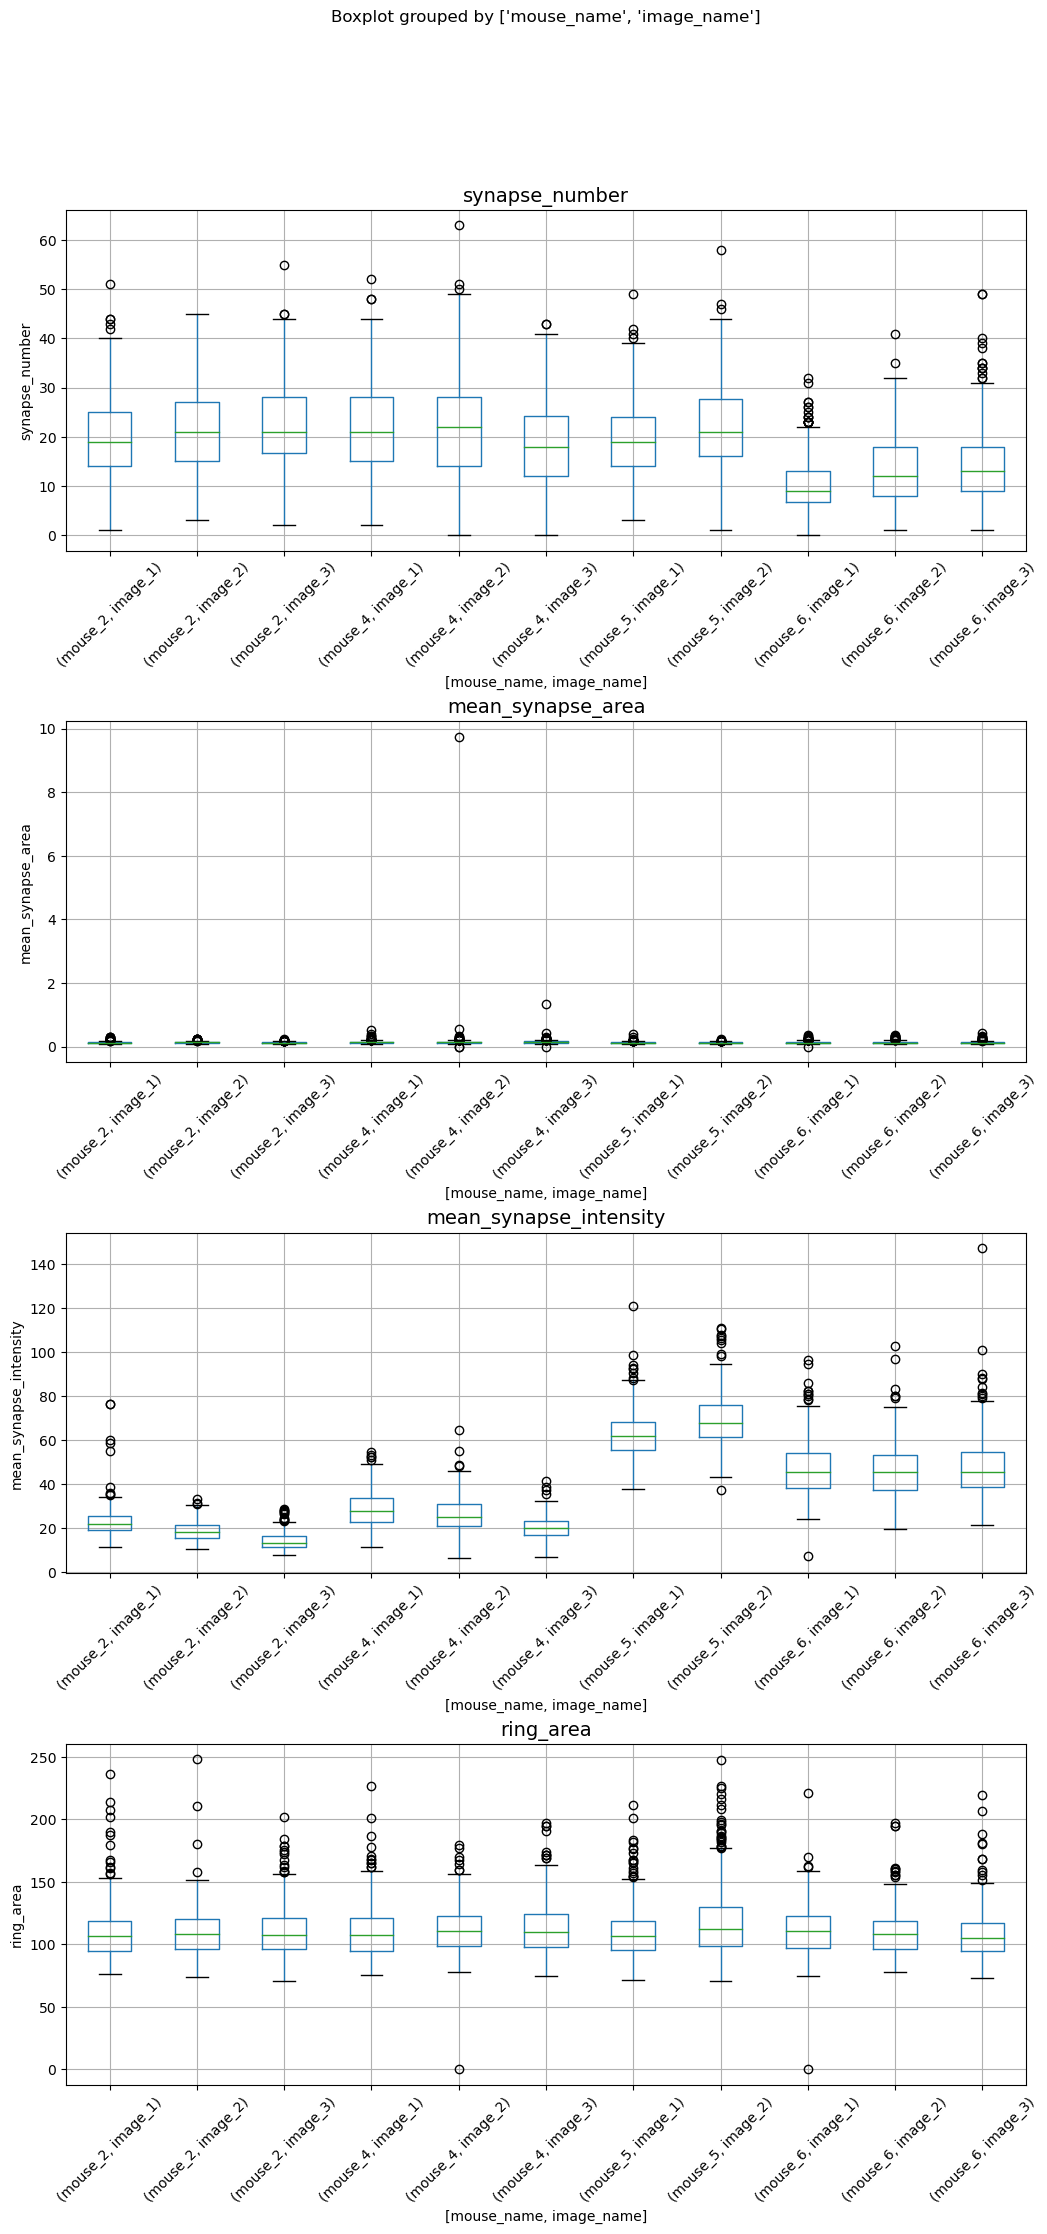

In [12]:
# what variables to inspect
to_inspect = ['synapse_number','mean_synapse_area','mean_synapse_intensity','ring_area']

# set up a subplot 
fig, axes = plt.subplots(nrows=len(to_inspect), ncols=1 , figsize=(12,25))

# add some space between subplots 
plt.subplots_adjust(hspace=0.5)

for idx,variable in enumerate (to_inspect):
    
    # use boxplot method 
    box_plot = data.boxplot([variable], by = ["mouse_name", "image_name"],figsize=(10,6),ax = axes[idx],rot=45)
    box_plot.set_title(variable,fontsize= 14)
    box_plot.set_ylabel (variable)


There seem to be some clear outliers. We remove them.

In [13]:
# Remove outliers
def remove_outliers (variable,group,df, grouping_variable,use_MAD = True):
    """Removes outliers from Data Frame
    
    Input:
    variable: --> what dependent variable to examine
    group: --> which value of the grouping_varibale to inspect for outliers
    df --> Data Fame with data 
    grouping_variable --> what variable to group observations on 
    use_MAD --> if True uses median absolute deviation to detect outliers, otherwise Standard Deviation.
    
    Output:
    processed_df --> df with identified outliers excluded
    """
    
    # how many sd from mean to remove outlier or how many median absolute deviations
    outlier_sd = 2.5
    mad_criterion = 3

    # mask of entries we are interested in
    mask = df[grouping_variable] == group
    
    if not use_MAD:
        # identify outliers by standard deviation
        st_dev = df.loc[mask,variable].std()
        mean_val =df.loc[mask,variable].mean()
        drop_these = (df.loc[mask,variable] > mean_val + outlier_sd*st_dev) | (df.loc[mask,variable] < mean_val - outlier_sd*st_dev) 
    else:
        
        # identify outliers by median absolute deviation
        median = statistics.median(df.loc[mask,variable])
        mad = statistics.median(np.abs(df.loc[mask,variable] - median))
        drop_these = abs(df.loc[mask,variable] - median) > mad_criterion*mad

    print(f"Removing {sum(drop_these)} outliers from {group}... ")
    
    
    # return new df 
    processed_df = df.copy()
    processed_df.loc[mask, variable] = df.loc[mask, variable][~drop_these]
    return(processed_df)
    
    
vars_to_process = ['synapse_number','mean_synapse_area','mean_synapse_intensity','ring_area']
all_image_id = data['unique_image_id'].unique()

for var in vars_to_process:
    for im_id in all_image_id:
        data = remove_outliers (var,im_id,data,'unique_image_id')

Removing 22 outliers from mouse_2_image_1... 
Removing 9 outliers from mouse_2_image_2... 
Removing 17 outliers from mouse_2_image_3... 
Removing 8 outliers from mouse_4_image_1... 
Removing 8 outliers from mouse_4_image_2... 
Removing 10 outliers from mouse_4_image_3... 
Removing 14 outliers from mouse_5_image_1... 
Removing 35 outliers from mouse_5_image_2... 
Removing 45 outliers from mouse_6_image_1... 
Removing 6 outliers from mouse_6_image_2... 
Removing 25 outliers from mouse_6_image_3... 
Removing 54 outliers from mouse_2_image_1... 
Removing 31 outliers from mouse_2_image_2... 
Removing 34 outliers from mouse_2_image_3... 
Removing 49 outliers from mouse_4_image_1... 
Removing 47 outliers from mouse_4_image_2... 
Removing 40 outliers from mouse_4_image_3... 
Removing 38 outliers from mouse_5_image_1... 
Removing 50 outliers from mouse_5_image_2... 
Removing 66 outliers from mouse_6_image_1... 
Removing 51 outliers from mouse_6_image_2... 
Removing 47 outliers from mouse_6_imag

Next we test the normality of the data

In [14]:
# Test for normality of residuals
def anderson_my_darling (variable,group,df,group_variable):
    """This function tests the normality of the data. Using the Anderson Darling test, since this test is better 
    for large sample sizes than the shapiro-wilk test.
    
    Input:
    variable --> What variable to use as dependent variable.
    group: --> which value of the grouping_varibale to inspect for normality.
    df --> Data Fame with data 
    grouping_variable --> what variable to group observations on 
    """

    # data to test
    mask = (df[group_variable] == group) & ~ df[variable].isnull()

    # perform anderson darling test
    anderson_darling_result = stats.anderson(df.loc[mask,variable])

    # print results if non-normal
    test_statistic = anderson_darling_result.statistic
    error_percentage = 5
    critical_value = anderson_darling_result.critical_values[np.where(anderson_darling_result.significance_level == error_percentage)]
    if test_statistic > critical_value:
        print(f"Non-normal distibution for {variable} image {group}")

    
vars_to_process = ['synapse_number','mean_synapse_area','mean_synapse_intensity']
all_image_id = data['unique_image_id'].unique()

for var in vars_to_process:
    for im_id in all_image_id:
        anderson_my_darling (var,im_id,data,'unique_image_id')


Non-normal distibution for synapse_number image mouse_2_image_1
Non-normal distibution for synapse_number image mouse_2_image_2
Non-normal distibution for synapse_number image mouse_2_image_3
Non-normal distibution for synapse_number image mouse_4_image_1
Non-normal distibution for synapse_number image mouse_4_image_2
Non-normal distibution for synapse_number image mouse_4_image_3
Non-normal distibution for synapse_number image mouse_5_image_1
Non-normal distibution for synapse_number image mouse_5_image_2
Non-normal distibution for synapse_number image mouse_6_image_1
Non-normal distibution for synapse_number image mouse_6_image_2
Non-normal distibution for synapse_number image mouse_6_image_3
Non-normal distibution for mean_synapse_area image mouse_2_image_1
Non-normal distibution for mean_synapse_area image mouse_2_image_2
Non-normal distibution for mean_synapse_area image mouse_2_image_3
Non-normal distibution for mean_synapse_area image mouse_4_image_1
Non-normal distibution for m

Damn ... However, not all is lost, since the model I want to use (a linear mixed effects model) specifically requires the residuals (errors) to be normally distributed. But let us first do a simple t-test. The central limit theorem (https://en.wikipedia.org/wiki/Central_limit_theorem) in combination with our large smaple size should result in the means of mice being normally distributes.

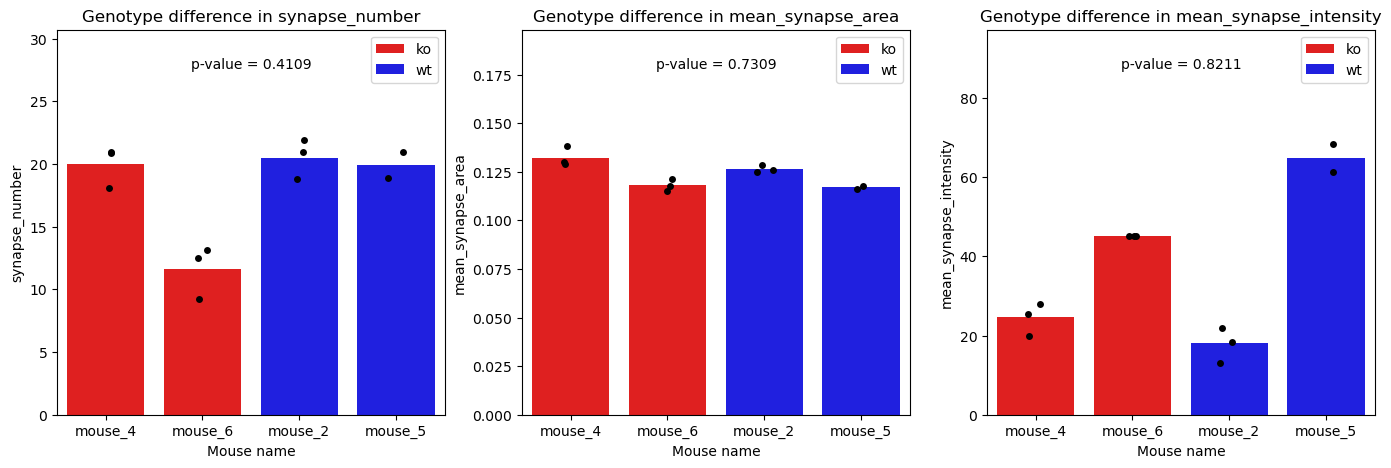

In [15]:
# Do a simple t-test on the mean of mice.
what_to_look_at = 'synapse_number'
def simple_genotype_ttest (what_to_look_at):
    """Performs a simple t-test on the group data
    Input:
    what_to_look_at --> dependent varibale """
    
    # gb_mice = data.groupby(['genotype','mouse_name'])[what_to_look_at].mean().reset_index(name='mouse_mean')
    wt_mice = data.loc[data['genotype'] == 'wt'].groupby('mouse_name')[what_to_look_at].mean().reset_index(name = 'means')
    ko_mice = data.loc[data['genotype'] == 'ko'].groupby('mouse_name')[what_to_look_at].mean().reset_index(name = 'means')
    
    # run t-test
    t_value,p_value = stats.ttest_ind(wt_mice['means'], ko_mice['means'])
    return(t_value,p_value)


# what variables we test
vars_to_process = ['synapse_number','mean_synapse_area','mean_synapse_intensity']

# create figure
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

# loop over variables and poplulate figure
for idx,var in enumerate(vars_to_process):
    
    # call funciton to perform t-test
    t,p = simple_genotype_ttest (var)
    
    # plot
    ax = axs[idx]
    plot_mice_and_images (data,var,p_value = p,ax_to_plot_on = ax)

Now let us use a model which is adequate for the nested data: a linear mixed effects model

In [16]:
# Construct a linear mixed effects model
def linear_mixed_effects_model (df,what_shall_we_test,cluster_level ="mouse_name",test_assumptions = True):
    """This function performs a linear mixed effects model and reports how well the assumptions are met.
    Inputs:
    df --> A Data Frame with column 'genotype'
    what_shall_we_test --> The dependent variable of interest
    cluster_level --> Defines what variable clusters (groups) the values of what_shall_we_test.
    test_assumptions --> If True will return a qq_plot and a plot to check the asssumtions of equal variance of residues.
    
    Outpus:
    model --> Out linear mixed effects model 
    qq_plot --> Plot to examine normality of residues
    equal_vars --> Plot to examine equal variance of residues """
        

    # select data 
    model_data = df[~ df[what_shall_we_test].isnull()]

    model = smf.mixedlm(what_shall_we_test+" ~ C(genotype)", data = model_data,groups= model_data[cluster_level]).fit()
    model.summary()

    if test_assumptions:
        # assumption plots 
        fig, (qq_plot,equal_vars) = plt.subplots(2,1,figsize=(16,9))

        # Normality of residuals
        sm.qqplot(model.resid, line = 's',ax=qq_plot)
        qq_plot.set (title= f"QQ plot (Normality of residuals) for {what_shall_we_test}")

        # Equal variance of residuals
        equal_vars.scatter(model.fittedvalues,model.resid)
        equal_vars.set(title = f"Errors per predicted value for {what_shall_we_test}")
        equal_vars.set_xlabel("Error")
        equal_vars.set_ylabel("Predicted value")
    else:
        qq_plot = None
        equal_vars = None
        
    return(model,qq_plot,equal_vars)
   

I tested the assumptions, bot here a quick demonstration that the residues are normal (dorts are close to the red line in the qq_plot and the variance of errors seems to be okay (the blue dots are roughly equally spread out in the vertical direction) 

C:\Users\Samuel\miniconda3\envs\progLab\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


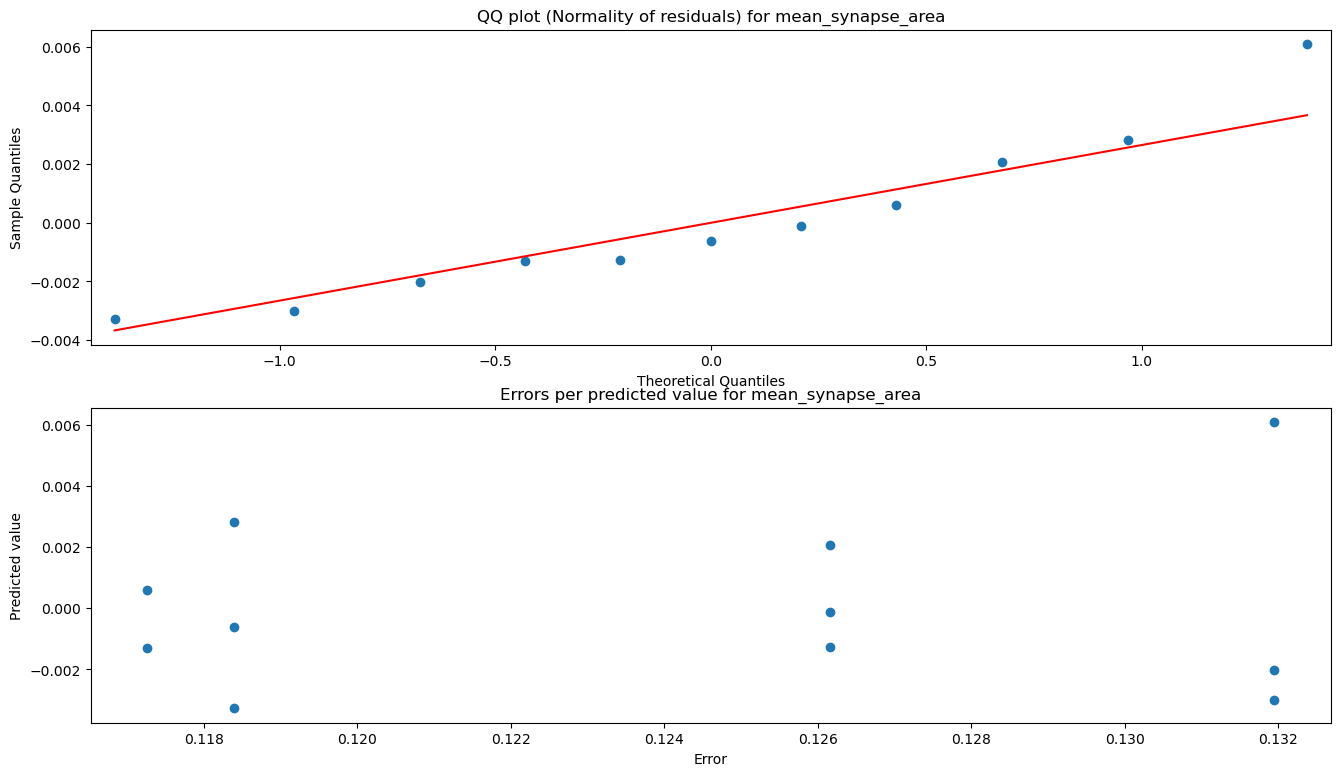

In [17]:
# call function once to demonstrate that residues tend to be noramal
var = 'mean_synapse_area'

# group on images
grouped_on_images = data.groupby(['genotype','mouse_name','image_name'])[var].mean().reset_index(name =var)

# call function
my_model,qq_plot,ev_plot=linear_mixed_effects_model(grouped_on_images,var)


C:\Users\Samuel\miniconda3\envs\progLab\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Samuel\miniconda3\envs\progLab\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


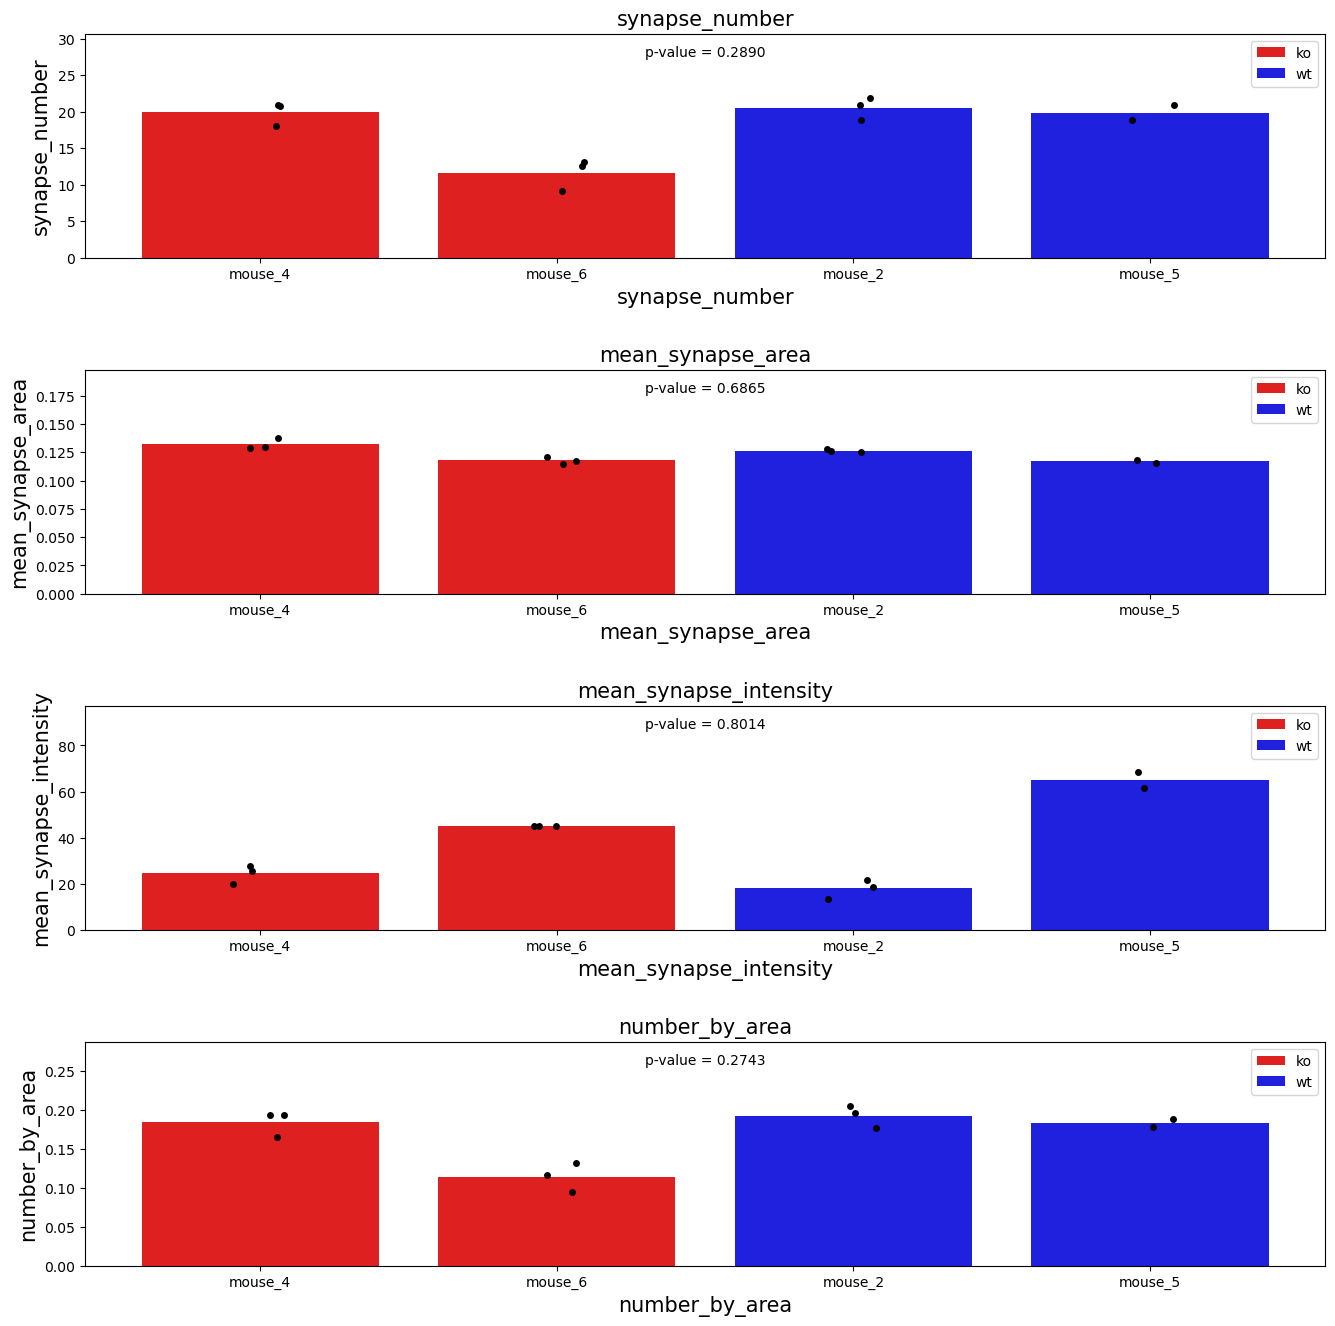

In [18]:
# process data on the level of mean image values
vars_to_process = ['synapse_number','mean_synapse_area','mean_synapse_intensity','number_by_area']

fig, axes = plt.subplots(nrows = len(vars_to_process),ncols = 1,figsize= (16,16))

# add some space between subplots 
plt.subplots_adjust(hspace=0.5)

for idx,var in enumerate(vars_to_process):
    
    # Construct data, whith a mean for each image
    grouped_on_images = data.groupby(['genotype','mouse_name','image_name'])[var].mean().reset_index(name = var)
    
    # contruct model and plot results
    my_model,qq_plot,ev_plot=linear_mixed_effects_model(grouped_on_images,var,test_assumptions = False)
    idx_of_effect = 1
    p_value = my_model.pvalues[idx_of_effect]
    
    # plot
    current_axes = plot_mice_and_images (data,var,p_value = p_value,ax_to_plot_on = axes[idx])
    current_axes.plot()
    current_axes.set_ylabel(var,fontsize = 15)
    current_axes.set_xlabel(var,fontsize = 15)
    current_axes.set_title(var,fontsize = 15)

Next we do the same thing, just on the level of individual synapses, not means of images

C:\Users\Samuel\miniconda3\envs\progLab\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Samuel\miniconda3\envs\progLab\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Samuel\miniconda3\envs\progLab\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Samuel\miniconda3\envs\progLab\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


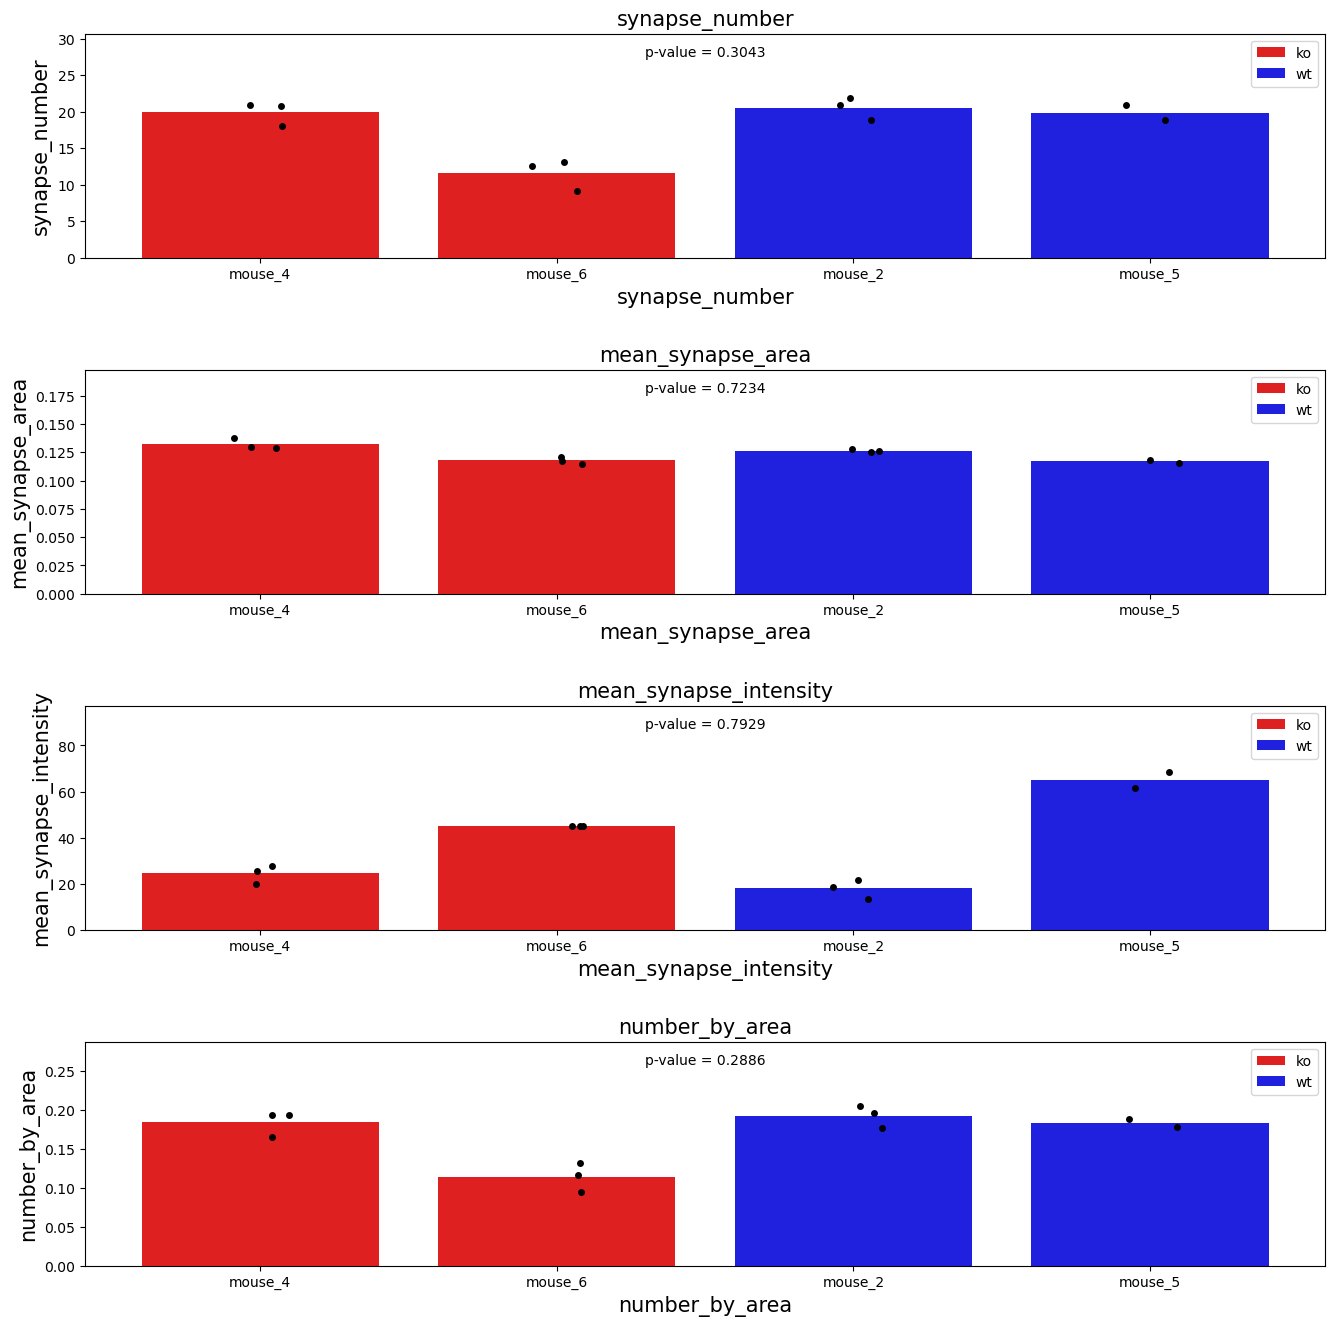

In [20]:
# process data on the level of synapses but grouped on mice
vars_to_process = ['synapse_number','mean_synapse_area','mean_synapse_intensity','number_by_area']

fig, axes = plt.subplots(nrows = len(vars_to_process),ncols = 1,figsize= (16,16))

# add some space between subplots 
plt.subplots_adjust(hspace=0.5)

for idx,var in enumerate(vars_to_process):
    
    # get data
    df = data.copy()
    
    # contruct model and plot results
    my_model,qq_plot,ev_plot=linear_mixed_effects_model(df,var,test_assumptions = False)
    idx_of_effect = 1
    p_value = my_model.pvalues[idx_of_effect]
    
    # plot
    current_axes = plot_mice_and_images (df,var,p_value = p_value,ax_to_plot_on = axes[idx])
    current_axes.plot()
    current_axes.set_ylabel(var,fontsize = 15)
    current_axes.set_xlabel(var,fontsize = 15)
    current_axes.set_title(var,fontsize = 15)


In summary it seems there is no significant effect of the genetic manipulation on the synapses. Let us look if the manipulation has an effect on the perineuronal nets around neurons.

# Part three: Image processing 

In [21]:
# import some nice image processing modules
from PIL import Image, ImageOps,ImageFilter
from IPython.display import display
from scipy.signal import convolve2d
import cv2

Again first load images.

In [22]:
# Create a mouse class to store all types of information about the mouse
class Mouse:
    def __init__(self,mouse_id,genotype):
        
        # set mouse unique identifier
        self.mouse_id = mouse_id
        
        # set the genotype
        self.genotype = genotype
        
        # store all image objects here 
        self.images = []
        
        # image names 
        self.image_names = []
        
        # store masks here 
        self.masks = []
        
        # segmented area 
        self.segmentation_area = []
        
        # average segmentation intensity
        self.segmentation_intensity = []
        

In [23]:
# record paths to data
# where the data of all mice is stored 
path_to_all_mice = r"data\wfa_images"

# folder names of mice
wt_image_folders = ["202209012","202209013"]
ko_image_folders = ["20221007","20221004"]


In [24]:
# store all mice objects here 
mice = []

# load images
for wt_folder,ko_folder in zip(wt_image_folders,ko_image_folders):
    
    # all image files
    wt_image_files = os.listdir(os.path.join(path_to_all_mice,wt_folder))
    ko_image_files = os.listdir(os.path.join(path_to_all_mice,ko_folder))
    
    # create new mouse object folder name is mouse id 
    new_wt_mouse = Mouse(wt_folder,'wt')
    new_ko_mouse = Mouse(ko_folder,'ko')
    
    # load wt images
    for wt_image_file in wt_image_files:
        
        # open image 
        wt_image = Image.open(os.path.join(path_to_all_mice,wt_folder,wt_image_file))
        
        # add to new mice objects
        new_wt_mouse.images.append(wt_image)
        new_wt_mouse.image_names.append(wt_image_file)
        
        
    for ko_image_file in ko_image_files:
         
        # open ko image
        ko_image = Image.open(os.path.join(path_to_all_mice,ko_folder,ko_image_file))

        # add to new ko mous object
        new_ko_mouse.images.append(ko_image)
        new_ko_mouse.image_names.append(ko_image_file)

    
    # store new mice objects 
    mice.append(new_wt_mouse)
    mice.append(new_ko_mouse)

Next we define the functions we use to analyze the image

In [25]:
# define image processing functions 
def create_mask(image,smooth_radius = 0.5,z_score = 1.5,erosion_ker_sz = (3,3) ,dialation_ker_sz = (7,7)):
    """This function creates a mask for an image based in the intensity and therfore segments it.
    
    Input:
    - image --> A PIL geay scale image object
    - smooth_radius --> 'Radius' of gaussian, which is used to smooth. Relates to how much smoothing to apply.
    - erosion_ker_sz = size of erosion square
    - dialation_ker_sz size of diatlation square 
    
    Outputs: 
    - a numpy array with 255 as pixel values that were identified as foreground and 0 as background """
    
    # convert to gray-scale if not already gray-scale 
    if image.mode != 'L':
        image = image.convert('L')
    
    # equalize histograms 
    image_equalized = ImageOps.equalize(image)
    
    
    # smoothing (gaussian) 
    image_smoothed = image_equalized.filter(ImageFilter.GaussianBlur(radius = smooth_radius))
    
    # turn into array
    image_array = np.array(image_smoothed)
    
    # create z-score threshold
    raw_mask = image_array > np.mean(image_array)+ z_score*np.std(image_array)
    
    # turn to uint8 type from bool (true/false) data type 
    # and multiply by 255 so that 1-values have highest value in gray-scale images
    raw_mask = raw_mask.astype(np.uint8) * 255
    
    # erode mask
    erode_n_times = 2
    kernel = np.ones(erosion_ker_sz,dtype= np.uint8)
    eroded_mask = cv2.erode(raw_mask,erosion_ker_sz, iterations = erode_n_times)

    # dialate mask
    dialation_kernel = np.ones(dialation_ker_sz,dtype= np.uint8)
    final_mask = cv2.dilate(eroded_mask, kernel, iterations=1)
    
    return(final_mask)
    

def extract_size_intensiy(image,mask,convert_to_microns = True ,one_pixel_in_microns = 0.5):
    """Function that takes an image and its segmentation mask and calculates the area of the semgentation as well as the
    average intensity.
    
    Input:
    - image: PIL grayscale image object
    - mask: uint8 nupy array where foreground pixels have value 255 and back ground ones have 0 value.
    - convert_to_microns: whether or not the values should be calculated with the unit microns (True) or pixels (False)
    - one_pixel_in_microns: how many microns one pixel spans. Not square microns but 'linear' microns
    
    Outputs: 
    - average_intensity
    - area_segmented 
    """
    
    # convert to gray-scale if not already gray-scale 
    if image.mode != 'L':
        image = image.convert('L')
    
    # get number of pixels segmented
    pix_number_segmented = np.sum(mask == 255)
    
    # convert unit
    if convert_to_microns:
        area_segmented = pix_number_segmented * one_pixel_in_microns**2
    else:
        area_segmented = pix_number_segmented


    # calculate mean image intensity (pixel value)
    image_array = np.array(image).astype(np.uint8)
    
    if (mask == 255).any():
        average_intensity = np.mean(image_array[mask == 255])
    else:
        average_intensity = 0
    
    return(area_segmented,average_intensity)



Now we apply the functions to analyze the images

In [26]:
# process mice images to create a segmentation 
for mouse in mice:

    # apply create_mask to images 
    mouse.masks = list(map(create_mask,mouse.images))

The original image...


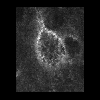

The segmentation result...


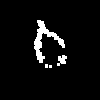

In [27]:
# lets have a look at the segmentations
example_mouse = 0
example_image = 0
mask,image =  mice[example_mouse].masks[example_image],mice[example_mouse].images[example_image]
print('The original image...')
display(image)
print('The segmentation result...')
display(Image.fromarray(mask))


Finally we quantify the perineuronal nets segmented from the images and apply functions from above

In [28]:
# quantify the segmented structures 
for mouse in mice:
    
    # create a zipped list of tupples containing first the images, then the mask, on which we can apply a the extract_size_intensity
    images_and_masks = list(zip(mouse.images,mouse.masks))

    # apply extract_size_intensiy and get a list of tupples where one tupple is the result of one image analysis
    list_of_results_tupples = list(map(lambda x: extract_size_intensiy(x[0],x[1],convert_to_microns=False),images_and_masks))

    # extract the tupple elements to different lists 
    mouse.segmentation_area = [my_tupple[0] for my_tupple in list_of_results_tupples]
    mouse.segmentation_intensity = [my_tupple[1] for my_tupple in list_of_results_tupples]

In [29]:
# Create a dict by creating one large list of results also adding mouse_id and genotype 
segmentation_dict = {'Area': list(itertools.chain(*[my_mouse.segmentation_area for my_mouse in mice])),
                    'Intensity':list(itertools.chain(*[my_mouse.segmentation_intensity for my_mouse in mice])),
                    'mouse_name': list(itertools.chain(*[[my_mouse.mouse_id]*len(my_mouse.images) for my_mouse in mice])),
                    'image_name': list(itertools.chain(*[my_mouse.image_names for my_mouse in mice])),
                    'genotype': list(itertools.chain(*[[my_mouse.genotype]*len(my_mouse.images) for my_mouse in mice]))
                    }

# create dataframe from dict
segmentation_df = pd.DataFrame(segmentation_dict)


Removing 8 outliers from 202209012... 
Non-normal distibution for Area image 202209012
Removing 0 outliers from 20221007... 
Non-normal distibution for Area image 20221007
Removing 1 outliers from 202209013... 
Removing 0 outliers from 20221004... 
Non-normal distibution for Area image 20221004
Removing 4 outliers from 202209012... 
Removing 9 outliers from 20221007... 
Non-normal distibution for Intensity image 20221007
Removing 10 outliers from 202209013... 
Non-normal distibution for Intensity image 202209013
Removing 2 outliers from 20221004... 


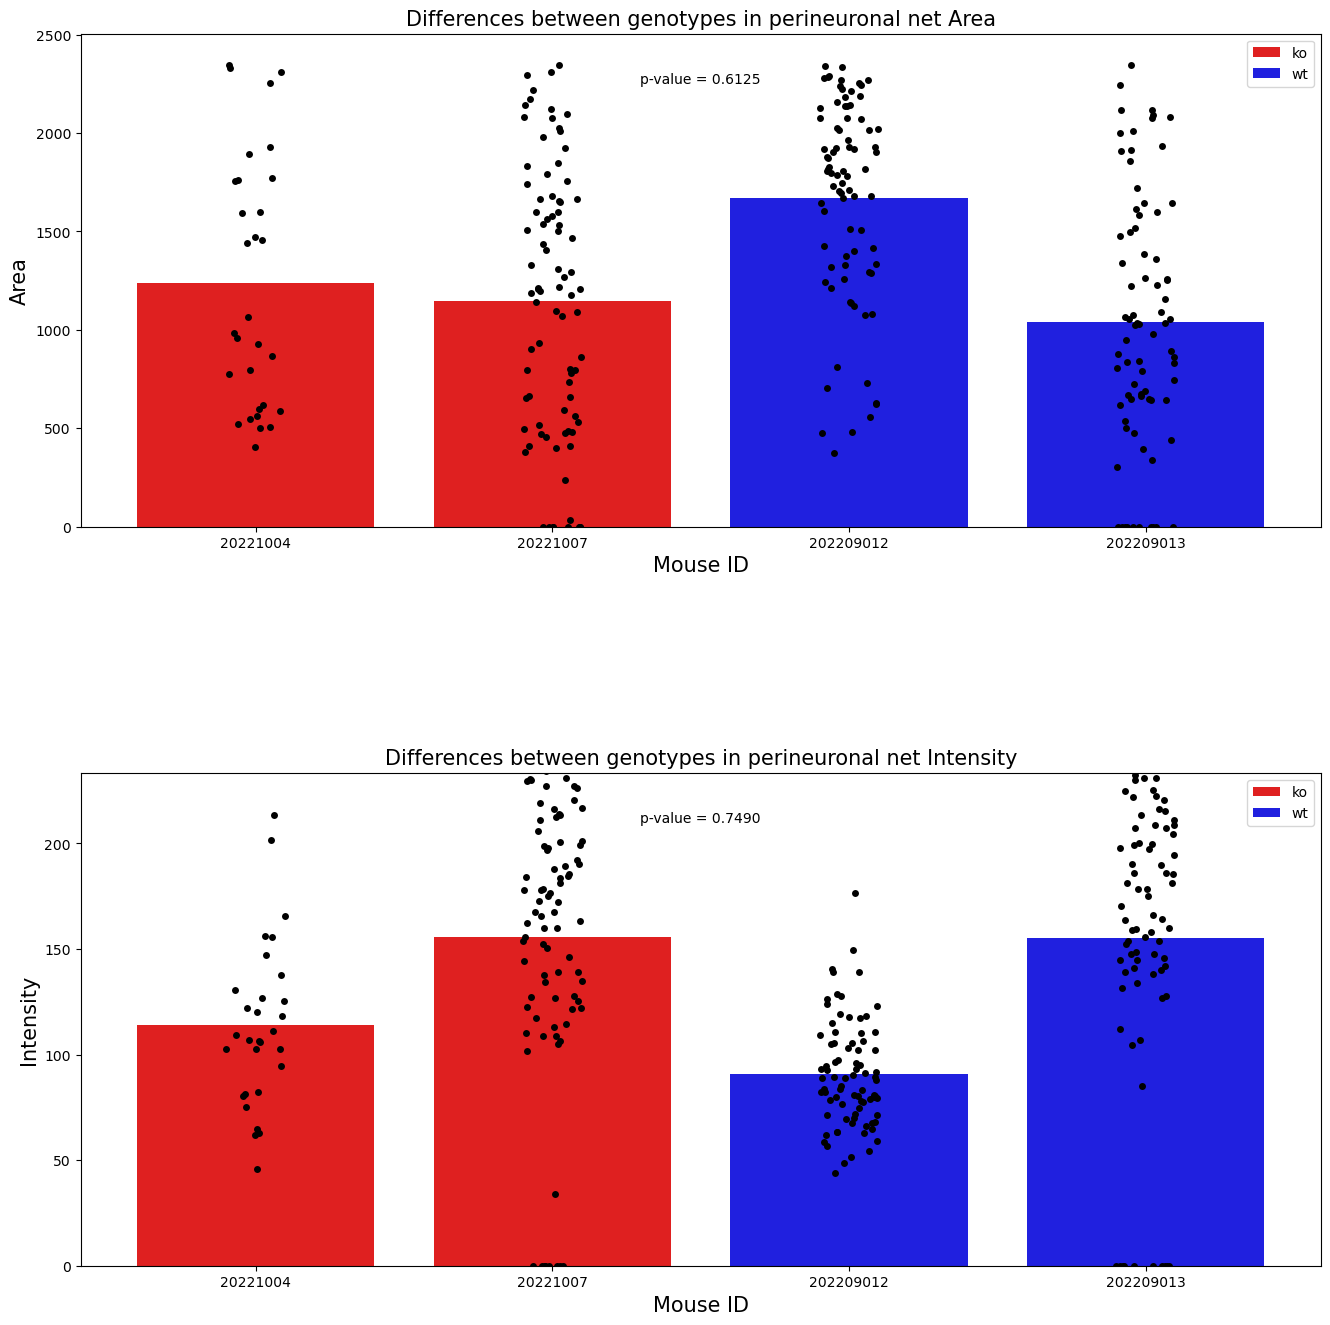

In [31]:
# once again do some visualizations and stats

# process data on the level of synapses but grouped on mice
vars_to_process = ['Area','Intensity']

# plot to populate
fig, axes = plt.subplots(nrows = len(vars_to_process),ncols = 1,figsize= (16,16))

# add some space between subplots 
plt.subplots_adjust(hspace=0.5)

for idx,var in enumerate(vars_to_process):
    
    
    # get data
    df = segmentation_df.copy()

    # remove outliers for each mouse and check for normality
    for group in segmentation_df['mouse_name'].unique():
        
        # outliers 
        remove_outliers (var,group,df,"mouse_name")

        # normailty 
        anderson_my_darling (var,group,df,"mouse_name")
    
    # contruct model and plot results
    my_model,qq_plot,ev_plot=linear_mixed_effects_model(df,var,cluster_level ="mouse_name",test_assumptions = False)
    idx_of_effect = 1
    p_value = my_model.pvalues[idx_of_effect]
    
    # plot
    current_axes = plot_mice_and_images (df,var,p_value = p_value,ax_to_plot_on = axes[idx])
    current_axes.plot()
    current_axes.set_ylabel(var,fontsize = 15)
    current_axes.set_xlabel('Mouse ID',fontsize = 15)
    current_axes.set_title(f"Differences between genotypes in perineuronal net {var}",fontsize = 15)

Also for perineuronal nets there seems to be no signifficant effect of the genetic manipulation.